In [11]:
# Export requirements.txt for only the packages used in this notebook
# pip install pipreqs
# !pipreqs --force .
import os
import re
import glob
import time
import pandas as pd
import warnings
import win32com.client as win32
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
import nltk 
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')
set_config(display='diagram')
dir_path = os.getcwd() + '\\'

# Only works in Windows with Excel installed
def set_options(xl, option):
    try:
        xl.Visible = option
        xl.ScreenUpdating = option
        xl.DisplayAlerts = option
        xl.EnableEvents = option
    except: 
        pass

def convert(file):
    file = os.path.splitext(file)[0]
    print("Converting {}...".format(file))
    xl = win32.gencache.EnsureDispatch('Excel.Application')
    set_options(xl, False)

    # check if file with .csv exists
    if not os.path.isfile(dir_path + file + '.csv'):
        try:
            wb = xl.Workbooks.Open(Filename= dir_path + file + '.xlsx',ReadOnly=1)
        except:
            wb = xl.Workbooks.Open(Filename= dir_path + file + '.xlsb',ReadOnly=1)  
        xl.ActiveWorkbook == wb
        
        #6 means csv
        wb.SaveAs(Filename= dir_path + file + '.csv', FileFormat='6') 
        set_options(xl, True)
        wb.Close(True)
        xl.Application.Quit()
        wb=xl=None
    
    df = pd.read_csv(dir_path + file + '.csv', low_memory = False, encoding='utf-8')
    df.to_pickle(dir_path + file + '.pkl')

    print("Done converting {}...".format(file))
    return file + '.pkl'

def read(i):
    try:
        pkl = glob.glob(os.path.join('*{0}*.pkl'.format(i)))[0]
    except: 
        pkl = convert(glob.glob(os.path.join('*{0}*'.format(i)))[0])
    df = pd.read_pickle(dir_path + pkl)
    return df

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\YongLe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\YongLe\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [12]:
# Pickle dataset, delete resume.pkl if you are facing issues
i = "train"
df = read(i)

df.head()

Converting train...
Done converting train...


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [13]:
# To make it more realistic, we shouldn't use the keyword and location as features, but we can use to stratify the data for the train and test sets later on
# Those with NaN, replace with others
df['keyword'] = df['keyword'].fillna('others')

# Do a brief cleaning of the data
df['text'] = [re.sub('\s+', ' ', x) for x in df['text']] # This removes all extra spaces
df['text'] = [x.lower() for x in df['text']] # lowercase 

df.head()


,id,keyword,location,text,target
0,1,others,NaN,our deeds are the reason of this #earthquake m...,1
1,4,others,NaN,forest fire near la ronge sask. canada,1
2,5,others,NaN,all residents asked to 'shelter in place' are ...,1
3,6,others,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,others,NaN,just got sent this photo from ruby #alaska as ...,1


In [18]:
# Number of rows of 1 and 0
print(df['target'].value_counts())

0    4342
1    3271
Name: target, dtype: int64


In [48]:
# Check for duplicates
df_mislabeled = df.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target'] 
df_mislabeled


text
#allah describes piling up #wealth thinking it would last #forever as the description of the people of #hellfire in surah humaza. #reflect    2
he came to a land which was engulfed in tribal war and turned it into a land of peace i.e. madinah. #prophetmuhammad #islam                   2
mmmmmm i'm burning.... i'm burning buildings i'm building.... oooooohhhh oooh ooh...                                                          2
.potus #strategicpatience is a strategy for #genocide; refugees; idp internally displaced people; horror; etc. https://t.co/rqwuoy1fm4        2
that horrible sinking feeling when youâãâªve been at home on your phone for a while and you realise its been on 3g this whole time          2
hellfire is surrounded by desires so be careful and donâãâªt let your desires control you! #afterlife                                       2
i pledge allegiance to the p.o.p.e. and the burning buildings of epic city. ??????                                                 

In [46]:
# Tweets that are truly disaster tweets are:
# .potus #strategicpatience is a strategy for #genocide; refugees; idp internally displaced people; horror; etc. https://t.co/rqwuoy1fm4        2
# cleared:incident with injury:i-495 inner loop exit 31 - md 97/georgia ave silver spring                                                       2
# who is bringing the tornadoes and floods. who is bringing the climate change. god is after america he is plaguing her #farrakhan #quote       2
# rt notexplained: the only known image of infamous hijacker d.b. cooper. http://t.co/jlzk2hdetg                                                2
# caution: breathing may be hazardous to your health.                                                                                           2

# Drop those tweets
not_mislabelled = ['.potus', 'cleared:incident', 'who is bringing', 'rt notexplained', 'caution: breathing']
df_mislabeled = df_mislabeled[~df_mislabeled.index.str.contains('|'.join(not_mislabelled))]
df_mislabeled.shape

(13,)

In [50]:
# Label the rest of df_mislabelled as 0
df.loc[df['text'].isin(df_mislabeled.index), 'target'] = 0

# Remove any duplicates
df = df.drop_duplicates(subset=['text'], keep='first')
df.shape

(7501, 5)

In [51]:
# Define X and y
X = df['text']
y = df['target']

In [98]:
# Create a RandomizedSearchCV function to find the best parameters/hyperparameters tuning
def RandomizedSearchCV_function(classifier, parameters, tune=True, X_train=None, y_train=None):
    start_time = time.time()
    # Define column transformer and pipeline
    pipeline = Pipeline([
        ('vect', TfidfVectorizer(analyzer='word',strip_accents=None, encoding='utf-8',preprocessor=None,ngram_range=(1, 2),token_pattern=r'(?u)\b\w[\w-]*\w\b|\b\w+\b', stop_words='english')),
        ('clf', classifier)
    ])

    # Create a randomized search cross validation and no verbose
    if tune:
        random_search = HalvingRandomSearchCV(pipeline, parameters, scoring='f1', n_jobs=-1, cv=5, verbose=0, random_state=2023)
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        print('Best score for {}: {}'.format(classifier.__class__.__name__, random_search.best_score_))
        print('Best parameters: {}'.format(random_search.best_params_))
    else:
        best_model = pipeline.fit(X_train, y_train)
        print('Score: {}: {}'.format(classifier.__class__.__name__, best_model.score(X_train, y_train)))
        print('Parameters: {}'.format({k: v for k, v in best_model.get_params().items() if k in parameters}))
        
    print('Time taken: {:.2f} seconds'.format(time.time() - start_time))
    print('='*50)
    return best_model[:2]

# Create a custom function to show performance and importance of features
def show_performance(model_name, model, mode="full", X_test=None, y_test=None):
    # Predict the test set
    y_pred = model.predict(X_test)

    # Show scores
    precision = precision_score(y_test, y_pred, average='binary') 
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    print('Model: {}'.format(model_name))
    print('Precision score: {:.2f}'.format(precision))
    print('Recall score: {:.2f}'.format(recall))
    print('F1 score: {:.2f}'.format(f1))

    # Full mode
    if mode == "full":
        print('Classification report of {} is:'.format(model_name))
        print(classification_report(y_test, y_pred))
        plt.figure(figsize=(10, 10))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', linewidths=.5, square=True, cmap='Blues_r')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        all_sample_title = 'Accuracy Score: {:.2f}'.format(accuracy_score(y_test, y_pred))
        plt.title(all_sample_title, size=15)
        plt.show()
        # ROC AUC score if model has predict_proba method
        if hasattr(model, 'predict_proba'):
            print('ROC AUC score: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))
        else:
            confidence = model.decision_function(X_test)
            confidence = confidence / np.sum(confidence, axis=1, keepdims=True)
            roc_auc_score(y_test, confidence)

        # Get the feature importance
        if hasattr(model, 'final_estimator_'):
            feature_importance = model.final_estimator_.coef_
            models = model.named_estimators_
            classes = model.classes_
            # columns should be the name of the sub models
            importance = pd.DataFrame(feature_importance, columns=models.keys())
            return importance
        elif hasattr(model.steps[1][1], 'coef_'):
            feature_importance = model.steps[1][1].coef_
        elif hasattr(model.steps[1][1], 'feature_importances_'):
            feature_importance = model.steps[1][1].feature_importances_

        # Normalize the importance to 2dp
        try:
            feature_importance = 100.0 * (feature_importance / feature_importance.max())
            importance = pd.DataFrame({'importance_'+model_name: feature_importance[0]}, index=model.steps[0][1].get_feature_names())
            importance = importance.sort_values('importance_'+model_name, ascending=False)
            # Show the feature importance dataframe
            print('Feature importance of {} is:'.format(model_name))
            print(importance)
        except:
            print('No feature importance for {}'.format(model_name))
    print('='*50)
    
    return model_name, precision, recall, f1

def bulk_train(X_train=None, y_train=None, tune=True):
    best_log = ["LogisticRegression",RandomizedSearchCV_function(LogisticRegression(), {'clf__C': (0.01, 0.1, 1),'clf__penalty': ('l1', 'l2'),'clf__solver': ('lbfgs','saga')}, tune=tune, X_train=X_train, y_train=y_train)]
    best_rf = ["RandomForestClassifier",RandomizedSearchCV_function(RandomForestClassifier(), {'clf__n_estimators': (100, 200, 300, 400, 500),'clf__max_depth': (10, 20, 30, 40, 50, None),'clf__min_samples_split': (2, 5, 10, 15, 100),'clf__min_samples_leaf': (1, 2, 5, 10)}, tune=tune, X_train=X_train, y_train=y_train)]
    best_xgb = ["XGBClassifier",RandomizedSearchCV_function(xgb.XGBClassifier(), {'clf__n_estimators': np.arange(100,300), 'clf__learning_rate': [0.0001,None,0.1,1], 'clf__n_jobs': (-1,)}, tune=tune, X_train=X_train, y_train=y_train)]
    best_lgbm = ["LGBMClassifier",RandomizedSearchCV_function(LGBMClassifier(), {'clf__verbose': (-1,), 'clf__n_jobs': (-1,), 'clf__reg_alpha': np.arange(0.1,1,0.1), 'clf__reg_lambda': np.arange(0.1,1,0.1), 'clf__max_depth': (-1,), 'clf__silent': (True,)}, tune=tune, X_train=X_train, y_train=y_train)]

    best_models = [best_log, best_rf, best_xgb, best_lgbm]
    return best_models
    

# All Models

In [67]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023, stratify=y)

# Train the models
best_models = bulk_train(X_train, y_train, tune=False)

Score: LogisticRegression: 0.9016666666666666
Parameters: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Time taken: 0.68 seconds
Score: RandomForestClassifier: 0.9996666666666667
Parameters: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Time taken: 18.17 seconds
Score: XGBClassifier: 0.87
Parameters: {'clf__learning_rate': None, 'clf__n_estimators': 100, 'clf__n_jobs': None}
Time taken: 0.70 seconds
Score: LGBMClassifier: 0.8523333333333334
Parameters: {'clf__max_depth': -1, 'clf__n_jobs': -1, 'clf__reg_alpha': 0.0, 'clf__reg_lambda': 0.0, 'clf__silent': 'warn'}
Time taken: 0.61 seconds


In [68]:
# Create a dataframe to show the performance of the models
performance = [show_performance(*model, mode='lite', X_test=X_test, y_test=y_test) for model in best_models]
df_performance = pd.DataFrame(performance, columns=['Model', 'Precision', 'Recall', 'F1'])
df_performance.sort_values('F1', ascending=False)

Model: LogisticRegression
Precision score: 0.74
Recall score: 0.68
F1 score: 0.71
Model: RandomForestClassifier
Precision score: 0.86
Recall score: 0.52
F1 score: 0.65
Model: XGBClassifier
Precision score: 0.84
Recall score: 0.51
F1 score: 0.64
Model: LGBMClassifier
Precision score: 0.81
Recall score: 0.61
F1 score: 0.70


,Model,Precision,Recall,F1
0,LogisticRegression,0.736486,0.683386,0.708943
3,LGBMClassifier,0.807851,0.612853,0.696970
1,RandomForestClassifier,0.861979,0.518809,0.647750
2,XGBClassifier,0.844156,0.509404,0.635386


Now we try to tune the models to see if we can get better results.

In [72]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023, stratify=df['keyword'])

# Train the models
best_models = bulk_train(X_train, y_train)

Best score for LogisticRegression: 0.5027257799671594
Best parameters: {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': 1}
Time taken: 0.60 seconds
Best score for RandomForestClassifier: 0.592349432654024
Best parameters: {'clf__n_estimators': 200, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_depth': 50}
Time taken: 44.43 seconds
Best score for XGBClassifier: 0.6197140103349104
Best parameters: {'clf__n_jobs': -1, 'clf__n_estimators': 291, 'clf__learning_rate': 0.1}
Time taken: 17.12 seconds
Best score for LGBMClassifier: 0.42811959028398194
Best parameters: {'clf__verbose': -1, 'clf__silent': True, 'clf__reg_lambda': 0.4, 'clf__reg_alpha': 0.1, 'clf__n_jobs': -1, 'clf__max_depth': -1}
Time taken: 1.72 seconds


In [73]:
# Create a dataframe to show the performance of the models
performance = [show_performance(*model, mode='lite', X_test=X_test, y_test=y_test) for model in best_models]
df_performance = pd.DataFrame(performance, columns=['Model', 'Precision', 'Recall', 'F1'])
df_performance.sort_values('F1', ascending=False)

Model: LogisticRegression
Precision score: 0.77
Recall score: 0.67
F1 score: 0.72
Model: RandomForestClassifier
Precision score: 0.94
Recall score: 0.43
F1 score: 0.58
Model: XGBClassifier
Precision score: 0.89
Recall score: 0.53
F1 score: 0.67
Model: LGBMClassifier
Precision score: 0.82
Recall score: 0.63
F1 score: 0.71


,Model,Precision,Recall,F1
0,LogisticRegression,0.767196,0.670262,0.715461
3,LGBMClassifier,0.823529,0.625578,0.711033
2,XGBClassifier,0.894330,0.534669,0.669238
1,RandomForestClassifier,0.935593,0.425270,0.584746


# Simple Stacking Classifier

In [111]:
def stacking(df, best_models, threshold=0.6, X_test=None, y_test=None):
    # Create a stacking classifier
    stack = StackingClassifier(estimators=[best_models[i] for i in df[df['F1'] >= threshold].index], n_jobs=-1, passthrough=False, verbose=1)
    stack.fit(X_train, y_train)

    # Show the performance of the stacking classifier
    imp_stack = show_performance('StackingClassifier', stack, mode='full', X_test=X_test, y_test=y_test)

    # Transpose the importance of each model
    imp_minmax = imp_stack.T.reset_index()
    imp_minmax.columns = ['Model', 'Importance']

    # Convert the importance to percentage
    imp_minmax['Importance'] = imp_minmax['Importance'] / imp_minmax['Importance'].sum() * 100
    imp_minmax['Importance'] = imp_minmax['Importance'].round(2).astype(str) + '%'
    print(imp_minmax)
    
    return stack, imp_minmax

Model: StackingClassifier
Precision score: 0.80
Recall score: 0.68
F1 score: 0.74
Classification report of StackingClassifier is:
              precision    recall  f1-score   support

           0       0.78      0.87      0.83       852
           1       0.80      0.68      0.74       649

    accuracy                           0.79      1501
   macro avg       0.79      0.78      0.78      1501
weighted avg       0.79      0.79      0.79      1501



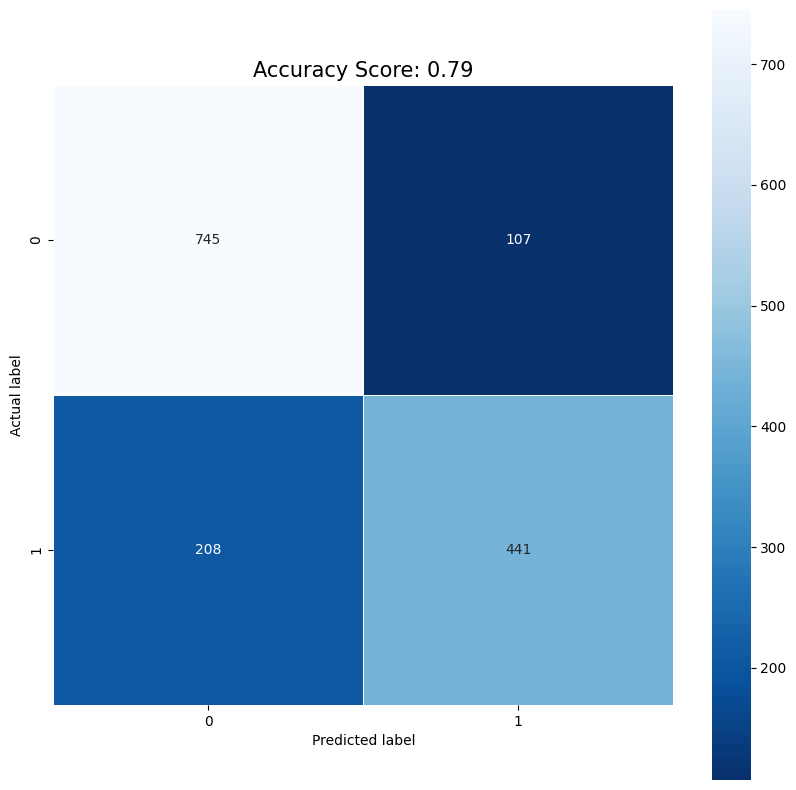

ROC AUC score: 0.86
                Model Importance
0  LogisticRegression     50.39%
1       XGBClassifier      31.9%
2      LGBMClassifier     17.71%


In [112]:
stack, imp_minmax = stacking(df_performance, best_models, X_test=X_test, y_test=y_test)

# Voting Classifier

In [115]:
def voting(df, best_models, threshold=0.6, X_test=None, y_test=None):
    # Create a Soft Voting Classifier
    vote = VotingClassifier(estimators=[best_models[i] for i in df[df['F1'] >= threshold].index], n_jobs=-1, verbose=1)
    vote.fit(X_train, y_train)

    # Show the performance of the voting classifier
    imp_vote = show_performance('VotingClassifier', vote, mode='lite', X_test=X_test, y_test=y_test)

    return vote, imp_vote

In [116]:
vote, imp_vote = voting(df_performance, best_models, X_test=X_test, y_test=y_test)

Model: VotingClassifier
Precision score: 0.86
Recall score: 0.62
F1 score: 0.72
